In [2]:
# # Install all important libraries
# !pip install yfinance
# !pip install ta

In [37]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

                           Close_Price  Regular_Returns
Date                                                   
2020-05-04 00:00:00-04:00    71.300346         0.014049
2020-05-05 00:00:00-04:00    72.370506         0.014898
2020-05-06 00:00:00-04:00    73.117157         0.010264
2020-05-07 00:00:00-04:00    73.873550         0.010292
2020-05-08 00:00:00-04:00    75.631866         0.023523
...                                ...              ...
2022-06-23 00:00:00-04:00   136.565094         0.021344
2022-06-24 00:00:00-04:00   139.913269         0.024221
2022-06-27 00:00:00-04:00   139.913269         0.000000
2022-06-28 00:00:00-04:00   135.745331        -0.030242
2022-06-29 00:00:00-04:00   137.513260         0.012940

[544 rows x 2 columns]


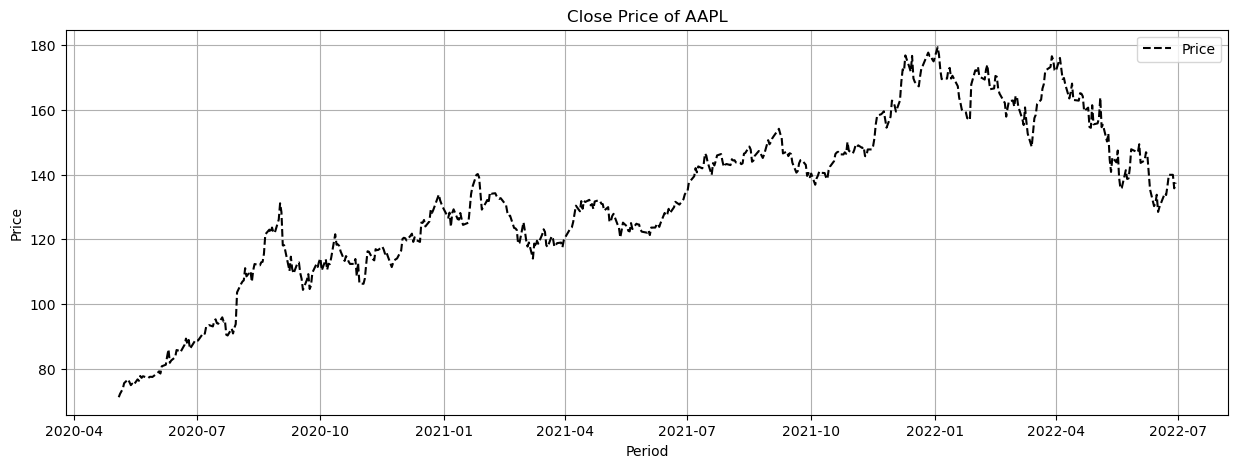

None
('2020-05-04', 71.30034637451172)


In [82]:
class Common_Class():

  def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True):
    """
      Args:
      symbol (str): The ticker symbol of the stock being analyzed (e.g., 'AAPL').
      start (str): The start date of the backtesting period in 'YYYY-MM-DD' format.
      end (str): The end date of the backtesting period in 'YYYY-MM-DD' format.
      interval (str): The data interval for trades, e.g., '1d' for daily data.
      capital (float): The initial amount of capital to start trading with.
      transaction_cost (float): The transaction cost as a decimal, e.g., 0.01 for 1%.

    """
    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital
    self.capital = capital
    self.transaction_cost = transcation_cost
    self.quantity = 0 # quantities to buy/sell
    self.position = 0 # the trades in progress, long or short
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade detail. the only change to store all the data
    self.prepare_data() # 

  def prepare_data(self):
    """
    Retrieves and calculates the regular returns of the stock and stores in self.data as a dataframe

    Returns:
      None
    """
    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

    stock_df = pd.DataFrame()
    stock_df["Close_Price"] = hist_stock["Close"]
    stock_df["Regular_Returns"] = np.log(stock_df["Close_Price"] / stock_df["Close_Price"].shift(1))
    stock_df = stock_df.dropna()
    self.data = stock_df

  def close_price_graph(self):
    """
    Plots a line graph of the close price of the symbol from the start to the end date

    Returns:
      None
    """
    plt.figure(figsize=(15, 5))
    plt.plot(self.data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Period")
    plt.ylabel("Price")
    plt.title("Close Price of {}".format(self.symbol))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, time_index):
    """
    Retrieves the date and closing price of the stock at a specified time index
    
    Args:
      time_index (int) = The index in the time series data representing a specific date.

    Returns:
      tuple: A tuple containing:
        - date (str): The date at the specified index in "YYYY-MM-DD" format.
        - price (float): The closing price of the stock on the specified date.

    Example:
      >>> return_date_price(0)
      ("2020-01-01", 159)
    """

    date = str(self.data.index[time_index])[:10]
    price = self.data.Close_Price.iloc[time_index]
    return date, price

  def realised_balance(self, time_index):
    """
    Calculates and displays the realised balance (available cash or liquid capital) in the account at a specific point in timee
    
    Args:
      time_index (int): The index representing a specific date in the data series.

    Returns:
      None
      
    Example:
      >>> self.realised_balance(10)
      Date :2022-05-01 | Realised Balance: 10000.0
    """

    date, price = self.return_date_price(time_index)
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, time_index):
    """
    Calculates and displays the unrealised balance, representing the current market value of open positions, in the account at a specified time.

    Args:
      time_index (int): The index representing a specific date in the data series.

    Returns:
      None

    Example:
      >>> self.unrealised_balance(10)
      Date :2022-05-01 | Unrealised Balance: 5000.0
    """
    date, price = self.return_date_price(time_index)
    # self.quantity = quantities to buy or sell
    ub = self.quantity *price
    print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, time_index):
    """
    Calculates and displays the total balance, including both realised (cash) and unrealised (open positions) balances, at a specified time.

    Args:
      time_index (int): The index representing a specific date in the data series.

    Returns:
      None

    Example:
      >>> self.total_balance(10)
      Date :2022-05-01 | Total Balance: 15000.0
    """
    date, price = self.return_date_price(time_index)
    tb = self.quantity *price + self.capital

    print("Date :{} | Total Balance: {:0.1f}".format(date,tb))

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    """
    Records the details of each trade into a dataframe for tracking and analysis purposes.
    Appends the trade details (trade ID, date, position, price, symbol, quantity, and capital)
    as a new row in `self.stored_data`.

    Args:
      trade (int): Either 0 for no trade or the current total number of trades executed.
      date (str): The date of the trade, formatted as 'YYYY-MM-DD'.
      position (int): The trade position, with 1 for long, -1 for short, and 0 for no position.
      price (float): The price at which the trade was executed.
      symbol (str): The ticker symbol of the asset being traded.
      quantity (int): The number of shares or units involved in the trade.
      capital (float): The total capital after executing the trade.

    Returns:
      None

    Example:
      >>> self.store_results(2, '2022-05-01', 1, 150.0, 'AAPL', 10, 10000.0)
      Appends a new row to `self.stored_data` with the trade details for 'AAPL' on 2022-05-01, marking the 2nd trade.
      >>> self.store_results(0, '2022-05-02', 0, 0, 'AAPL', 0, 10000.0)
      Appends a new row indicating no trade was made on '2022-05-02'.
    """
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  def buy_order(self, time_index, trades, quantity=None, dollar=None):
    """
    Buys shares for the self.symbol by either quantity or dollar amount. Adjusts capital to reflect transaction costs, updates position status, and stores the transaction details.

    Args:
      time_index (int): Index representing the specific point in time for the trade.
      trades (int): Number representing the number of trades that has been done
      quantity (int, optional): Number of shares to buy. If None, the quantity is calculated based on the dollar argument.
      dollar (float, optional): Dollar amount to spend on the buy order. Defaults to None.

    Returns:
      None

    Example:
      >>> self.buy_order(100, dollar=5000)
      Bought 10 shares of AAPL at 150.0 per share worth $1500.0

    Notes:
      - If `quantity` is not provided, it is calculated as `dollar / price`.
      - The capital is reduced based on the transaction cost.
    """
    date, price = self.return_date_price(time_index) # the current date and price
    if quantity == None: # if the dollar value of the buy order is specified
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity = self.quantity + quantity
    trades = trades + 1
    self.position = 1 #(To be stored in results. Will need for calculations)
    self.store_results(trades, date, self.position, price, self.symbol, quantity, self.quantity*price + self.capital)

    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(time_index)
      self.unrealised_balance(time_index)
      self.total_balance(time_index)

  def sell_order(self, time_index, trades, quantity=None, dollar=None):
    """
    Sells shares of the specified symbol by either quantity or dollar amount. Adjusts capital to account for transaction costs, updates position status, and stores the transaction details.

    Args:
      time_index (int): Index representing the specific point in time for the trade.
      quantity (int, optional): Number of shares to sell. If None, the quantity is calculated based on the dollar argument.
      dollar (float, optional): Dollar amount to generate from the sell order. Defaults to None.

    Returns:
      None

    Example:
      >>> self.sell_order(100, quantity=10)
      Sold 10 shares of AAPL at 150.0 per share worth 1500.0 $

    Notes:
      - If `quantity` is not provided, it is calculated as `dollar / price`.
      - The capital is increased based on the transaction cost.
    """
    date, price = self.return_date_price(time_index)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity = self.quantity - quantity
    trades = trades + 1
    self.position = -1
    self.store_results(trades, date, self.position, price, self.symbol, quantity, self.quantity*price + self.capital)

    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
      self.realised_balance(time_index)
      self.unrealised_balance(time_index)
      self.total_balance(time_index)

  def last_trade(self, time_index, trades):
    """
    Finalizes the open position by closing any remaining shares. Closes out any remaining shares by calculating the last trade. Updates the capital and position, logs the last trade, and outputs the final balance.

    Args:
      time_index (int): Index representing the specific point in time for the final trade.

    Returns:
        None

    Example:
      >>> self.last_trade(100)
      Closed open trades for 10 shares of AAPL at 150.0 per share worth 1500.0 $
        
    Notes:
      - If in a short position (`position == -1`), the position is bought to close with a positive quantity.
      - Adjusts capital by selling all remaining shares at the final price.
    """
    date, price = self.return_date_price(time_index)
    last_quantity = self.quantity
    self.capital = self.capital + last_quantity * price
    self.quantity = 0 # as no more quantity now. all will be settled
    trades = trades +1
    if self.position == -1: # if closing out a short position
      last_quantity = - last_quantity # to keep a positve number in records
      self.position = 1 # to record we are buying to close out
    else:
      last_quantity = last_quantity # to keep a positve nymber in records
      self.position = -1 # to record we are selling to close out

    self.store_results(trades, date, self.position, price, self.symbol, last_quantity, self.quantity*price + self.capital)
    print("=" *50)
    print("--------------Final Balance-----------")
    self.total_balance(time_index)
    print("=" *50)

    def get_position(self):
      return self.position
    
    def set_position(self, position):
      self.position = position

appl_strat = Common_Class("AAPL", "2020-05-01", "2022-06-30","1d",10000, 0.0, True)

print(appl_strat.data)
print(appl_strat.close_price_graph())
print(appl_strat.return_date_price(0))


In [86]:
class MA_Strategy():
  def __init__(self, stock: Common_Class):
    self.stock = stock

  def go_long(self, time_index, trades, quantity = None, dollar = None): # either previously in position or fresh position
    """
    Initiates or adds to a long position by buying shares of the stock. Executes a buy order to either close an existing short position or to open/increase a long position. If already in a short position, it clears the short by buying an equal quantity. If no quantity is specified, it calculates the amount based on the dollar input.

    Args:
      time_index (int): Index representing the specific point in time for the trade.
      quantity (int, optional): Number of shares to buy. Defaults to None. If provided, buys the specified quantity.
      dollar (float, optional): Dollar amount to invest in the buy order. Defaults to None. If 'all' is passed, invests the total capital available.

    Returns:
      None

    Example:
      >>> self.go_long(time_index=100, dollar='all')
      Bought shares of AAPL using all available capital at the current price.

    Notes:
      - If the current position is short (`position == -1`), it first clears the short position by buying back shares.
      - If `dollar` is 'all', the function uses the entire available capital to purchase shares.
      - Only one of `quantity` or `dollar` should be provided; if both are provided, `quantity` takes precedence.
    """
    if self.stock.position == -1:
      self.stock.position = 0
      self.stock.buy_order(time_index, trades, quantity = -self.stock.quantity) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.stock.buy_order(time_index, trades, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.stock.capital
      self.stock.buy_order(time_index, trades, dollar = dollar)

  def go_short(self, time_index, trades, quantity = None, dollar = None):
    """
    Initiates or adds to a short position by selling shares of the stock. Executes a sell order to either close an existing long position or to open/increase a short position. If already in a long position, it clears the long by selling an equal quantity. If no quantity is specified, it calculates the amount based on the dollar input.

    Args:
      time_index (int): Index representing the specific point in time for the trade.
      quantity (int, optional): Number of shares to sell. Defaults to None. If provided, sells the specified quantity.
      dollar (float, optional): Dollar amount to invest in the short order. Defaults to None. If 'all' is passed, sells the total capital available.

    Returns:
      None

    Example:
      >>> self.go_short(time_index=100, dollar='all')
      Sold shares of AAPL using all available capital at the current price.

    Notes:
      - If the current position is long (`position == 1`), it first clears the long position by selling shares.
      - If `dollar` is 'all', the function uses the entire available capital to sell shares.
      - Only one of `quantity` or `dollar` should be provided; if both are provided, `quantity` takes precedence.
    """
    if self.stock.position == 1:
      self.stock.position = 0
      self.stock.sell_order(time_index, trades, quantity = self.stock.quantity) #to clear previous long vposition
    if quantity:
      self.stock.sell_order (time_index, trades, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.stock.capital
      self.stock.sell_order(time_index, trades, dollar = dollar)


In [87]:
from typing import List
class EventBacktester():
    # i was thinking we should have capital parameters because we will prolly perform the efficient frontier to find the optimal capital weights 
    def __init__(self, stocklist: List[str], params, capital_weights):
        self.stocklist = stocklist # list of the stock symbols [apple, amzn, goog, etc]
        self.params = params # dictionary similar to our midterm
        self.capital_weights = capital_weights # dictionary
        self.start = "2010-01-01"
        self.end = "2016-12-31"
        self.interval = "1d"
        self.total_capital = 500000
        self.transaction_cost = 0
        self.verbose = True
        self.common_class_dict = {}
        self.MA_strat_dictionary = {}
        self.trades = 0 # trades is either 0 or another number. 0 meaning no trades has been done
        self.position = 0
        self.prepare_date()

    def prepare_date(self):
        for stock in self.stocklist:
            stock_capital = self.capital_weights[stock]*self.total_capital
            self.common_class_dict[stock] = Common_Class(stock, self.start, self.end, self.interval, stock_capital, self.transaction_cost, True)
            self.MA_strat_dictionary[stock] = MA_Strategy(self.common_class_dict[stock])
            indicator_1 = SMAIndicator(close = self.common_class_dict[stock].data ["Close_Price"], window = self.params['STMA_window'], fillna= False)
            STMA = indicator_1.sma_indicator()
            indicator_2 = SMAIndicator(close = self.common_class_dict[stock].data ["Close_Price"], window = self.params["LTMA_window"], fillna= False)
            LTMA = indicator_2.sma_indicator()
            self.common_class_dict[stock].data["STMA"] = STMA
            self.common_class_dict[stock].data["LTMA"] = LTMA

    def run_MA_Strategy(self):
        self.position = 0
        self.trades = 0
        values = list(self.common_class_dict.values())
        # this range will be different from strat to strat but most of the time i would believe it will be the shortest window in the parameters
        for time_index in range(self.params['LTMA_window'], values[0].data.shape[0]):
            for key in self.common_class_dict.keys():
                stock_df = self.common_class_dict[key]
                strategy = self.MA_strat_dictionary[key]
                date, price = stock_df.return_date_price(time_index)
                if time_index == values[0].data.shape[0]:
                    stock_df.last_trade(time_index, self.trades)
                    self.trades = self.trades + 1
                else:
                    if stock_df.position in [0,-1]:
                        if stock_df.data["STMA"].iloc[time_index] > stock_df.data["LTMA"].iloc[time_index]:
                            strategy.go_long(time_index, self.trades, dollar=5000)
                            self.trades+=1
                            continue
                    if stock_df.position in [0,1]:
                        if stock_df.data["STMA"].iloc[time_index] < stock_df.data["LTMA"].iloc[time_index]:
                            strategy.go_short(time_index, self.trades, dollar=5000)
                            self.trades+=1
                            continue 
                    #-----Storing all the values for calculating Sharpe-----
                    store_quantity = abs(stock_df.quantity) # so that I want just the positive numbers in my performance table. I will calculate +/- based on self.position sign
                    stock_df.store_results(0, date, stock_df.position, price, key, store_quantity, stock_df.quantity*price + stock_df.capital)


In [88]:
maang_stocks = [
    "MSFT",  # Microsoft
    "AAPL",  # Apple
    "AMZN",  # Amazon
    "NFLX",  # Netflix
    "GOOGL"  # Alphabet (Google)
]

params = {
    'STMA_window': 50,
    'LTMA_window': 200
}

capital_weights = {
    "MSFT": 0.2,
    "AAPL": 0.2,
    "AMZN":0.2,
    "NFLX":0.2,
    "GOOGL":0.2
}

E = EventBacktester(maang_stocks, params, capital_weights)
E.run_MA_Strategy()
for key in E.common_class_dict.keys():
    print(E.common_class_dict[key].stored_data)

Sold 258 shares of MSFT at 19.4 per share worth 4997.8 $
Date :2010-10-20 | Realised Balance: 104997.8
Date :2010-10-20 | Unrealised Balance: -4997.8
Date :2010-10-20 | Total Balance: 100000.0
Bought 533 shares of AAPL at 9.4 per share worth 4991.8 $
Date :2010-10-20 | Realised Balance: 95008.2
Date :2010-10-20 | Unrealised Balance: 4991.8
Date :2010-10-20 | Total Balance: 100000.0
Bought 630 shares of AMZN at 7.9 per share worth 4998.1 $
Date :2010-10-20 | Realised Balance: 95001.9
Date :2010-10-20 | Unrealised Balance: 4998.1
Date :2010-10-20 | Total Balance: 100000.0
Bought 228 shares of NFLX at 21.9 per share worth 4988.3 $
Date :2010-10-20 | Realised Balance: 95011.7
Date :2010-10-20 | Unrealised Balance: 4988.3
Date :2010-10-20 | Total Balance: 100000.0
Sold 329 shares of GOOGL at 15.2 per share worth 4993.3 $
Date :2010-10-20 | Realised Balance: 104993.3
Date :2010-10-20 | Unrealised Balance: -4993.3
Date :2010-10-20 | Total Balance: 100000.0
Bought 329 shares of GOOGL at 15.4 p

In [62]:
E.common_class_dict['GOOGL'].data

,Close_Price,Regular_Returns,STMA,LTMA
Date,,,,
2010-01-05 00:00:00-05:00,15.576794,-0.004413,NaN,NaN
2010-01-06 00:00:00-05:00,15.184123,-0.025532,NaN,NaN
2010-01-07 00:00:00-05:00,14.830644,-0.023555,NaN,NaN
2010-01-08 00:00:00-05:00,15.028353,0.013243,NaN,NaN
2010-01-11 00:00:00-05:00,15.005637,-0.001513,NaN,NaN
...,...,...,...,...
2016-12-23 00:00:00-05:00,40.290234,-0.002325,39.822792,39.822792
2016-12-27 00:00:00-05:00,40.396469,0.002633,39.828109,39.828109
2016-12-28 00:00:00-05:00,40.129135,-0.006640,39.825845,39.825845
